In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler, robust_scale, LabelEncoder
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC

In [2]:
train_image= pd.read_csv(r'C:\Users\Dell\OneDrive\Desktop\Level 3\ML\ProjectDataset-Arabic-Characters-Recognition\Arabic-Characters-Recognition\csvTrainImages 13440x1024.csv', header=None).values
train_label = pd.read_csv(r'C:\Users\Dell\OneDrive\Desktop\Level 3\ML\ProjectDataset-Arabic-Characters-Recognition\Arabic-Characters-Recognition\csvTrainLabel 13440x1.csv', header=None).values.ravel()

test_image = pd.read_csv(r'C:\Users\Dell\OneDrive\Desktop\Level 3\ML\ProjectDataset-Arabic-Characters-Recognition\Arabic-Characters-Recognition\csvTestImages 3360x1024.csv', header=None).values
test_label = pd.read_csv(r'C:\Users\Dell\OneDrive\Desktop\Level 3\ML\ProjectDataset-Arabic-Characters-Recognition\Arabic-Characters-Recognition\csvTestLabel 3360x1.csv', header=None).values.ravel()

In [3]:
unique_classes, counts = np.unique(train_label, return_counts=True)
len(unique_classes)

28

In [4]:
class_counts = pd.Series(train_label).value_counts().sort_index()

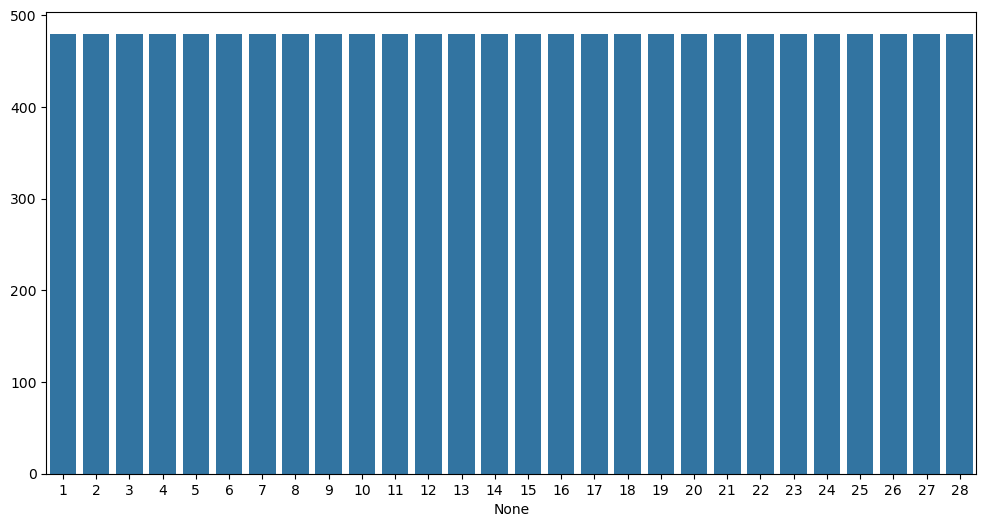

In [ ]:
plt.figure(figsize=(12,6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.show()

In [6]:
train_images = train_image / 255.0
test_images = test_image / 255.0

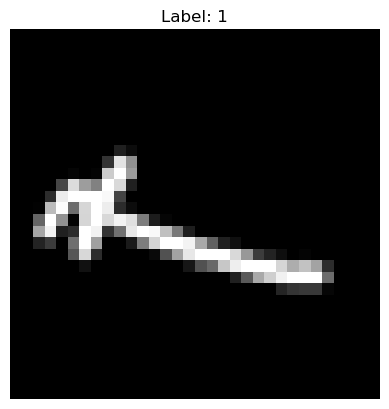

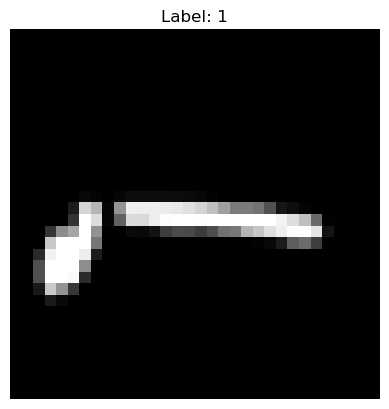

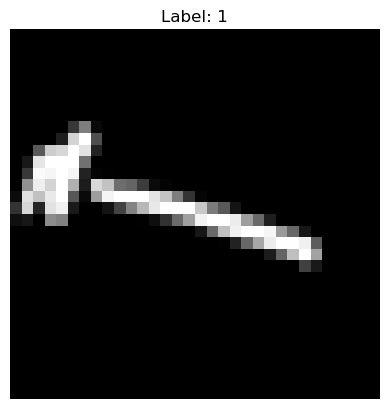

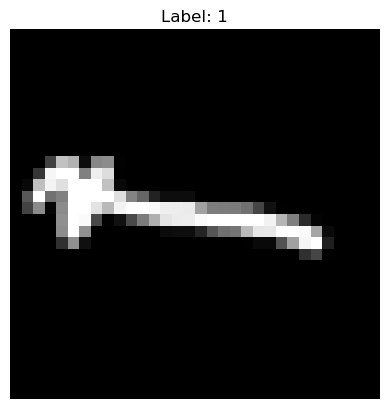

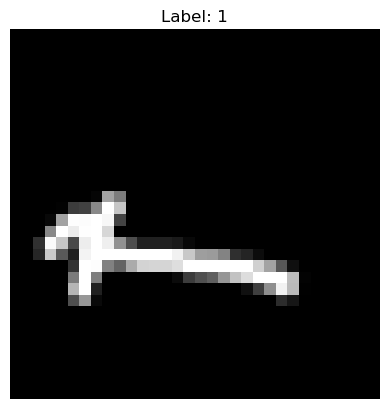

In [ ]:
def show_image(show, label=None):
    image = show.reshape(32, 32)
    plt.imshow(image, cmap='gray')
    if label is not None:
        plt.title(f"Label: {label}")
    plt.axis('off')
    plt.show()

for i in range(5):
    show_image(train_images[i], train_label[i])

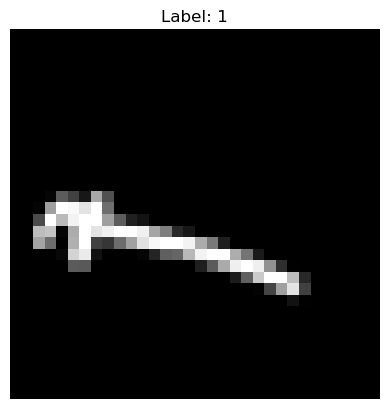

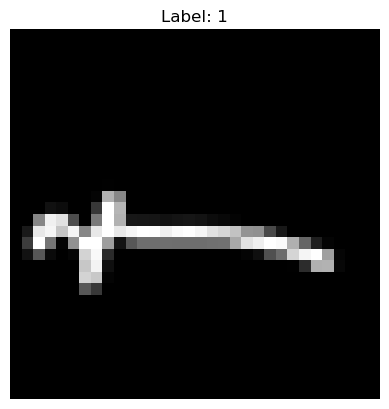

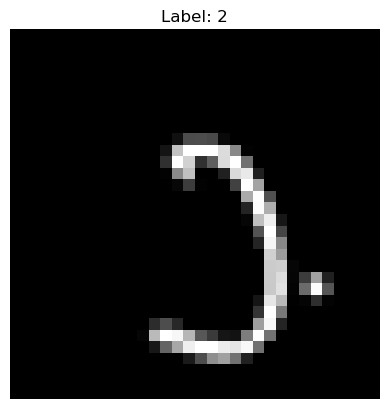

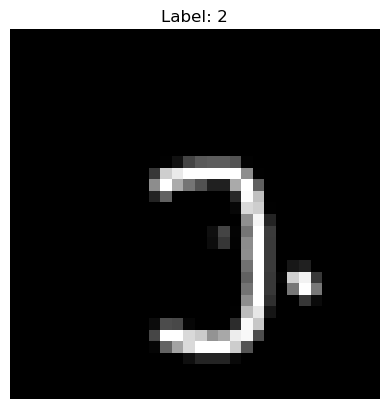

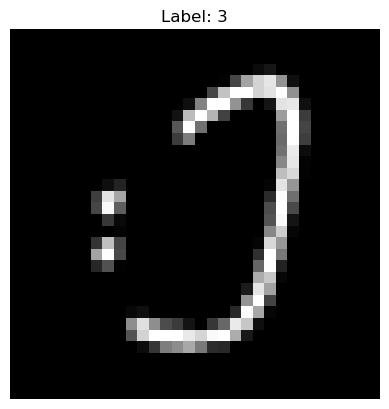

In [8]:
def show_image(show, label=None):
    image = show.reshape(32, 32)
    plt.imshow(image, cmap='gray')
    if label is not None:
        plt.title(f"Label: {label}")
    plt.axis('off')
    plt.show()

for i in range(5):
    show_image(test_images[i], test_label[i])

In [9]:
pca = PCA(n_components=50) 
train_pca = pca.fit_transform(train_images)
test_pca = pca.transform(test_images)

In [10]:
scaler =StandardScaler ()
X_train_scaled = scaler.fit_transform(train_pca)
X_test_scaled = scaler.transform(test_pca)

In [11]:
svm_model = SVC(kernel='rbf', C=50, gamma='scale')  
svm_model.fit(train_pca, train_label)
svm_preds = svm_model.predict(test_pca)
accuracy_score(test_label, svm_preds)

0.7791666666666667

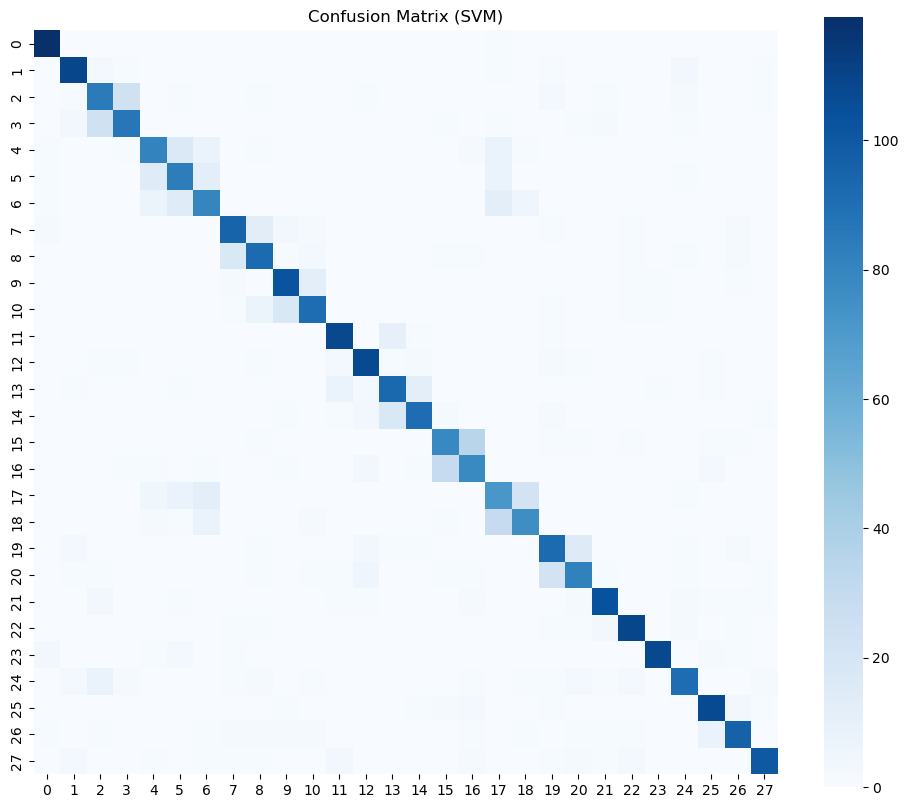

In [12]:
cm = confusion_matrix(test_label, svm_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, cmap="Blues", square=True, cbar=True, xticklabels=True, yticklabels=True)
plt.title("Confusion Matrix (SVM)")
plt.show()

In [ ]:
num_classes = len(np.unique(train_label))+1
train_labels_cat = to_categorical(train_label, num_classes=num_classes)
test_labels_cat = to_categorical(test_label, num_classes=num_classes)

In [14]:
def build_model_1():
    model = Sequential([
        Dense(256, input_shape=(1024,), activation='relu'),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')  
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [15]:
def build_model_2():
    model = Sequential([
        Dense(512, input_shape=(1024,), activation='relu'),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [16]:
def cross_validate_model(model_fn, X, y, k=5):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    accuracies = []

    for train_idx, val_idx in kf.split(X):
        model = model_fn()
        model.fit(X[train_idx], y[train_idx], epochs=10, batch_size=32, verbose=0)
        loss, acc = model.evaluate(X[val_idx], y[val_idx], verbose=0)
        accuracies.append(acc)

    return np.mean(accuracies)

In [17]:
acc_model1 = cross_validate_model(build_model_1, train_images, train_labels_cat)
acc_model2 = cross_validate_model(build_model_2, train_images, train_labels_cat)

c:\Users\Dell\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
print(acc_model1)
print(acc_model2)

0.7299107074737549
0.7416666626930237


In [19]:
best_model_fn = build_model_1 if acc_model1 > acc_model2 else build_model_2
print(f" {'Model 1' if best_model_fn == build_model_1 else 'Model 2'}")

 Model 2


In [20]:
best_model = best_model_fn()
best_model.fit(train_images, train_labels_cat, epochs=30, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/30
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2276 - loss: 2.5910 - val_accuracy: 0.4769 - val_loss: 1.6291
Epoch 2/30
336/336 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6094 - loss: 1.1355 - val_accuracy: 0.5755 - val_loss: 1.2558
Epoch 3/30
336/336 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7562 - loss: 0.6780 - val_accuracy: 0.5967 - val_loss: 1.2142
Epoch 4/30
336/336 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8451 - loss: 0.4418 - val_accuracy: 0.6321 - val_loss: 1.2246
Epoch 5/30
336/336 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8947 - loss: 0.3046 - val_accuracy: 0.6473 - val_loss: 1.2444
Epoch 6/30
336/336 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9201 - loss: 0.2271 - val_accuracy: 0.6603 - val_loss: 1.2918
Epoch 7/30
336/336 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9444 - loss: 0.1566 - val_accuracy: 0.6689 - val_loss: 1.3947
Epoch 8/30
336/336 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9670 - loss: 0.1063 - val_accuracy: 0.

In [21]:
test_loss, test_accuracy = best_model.evaluate(test_images, test_labels_cat)
test_accuracy

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7502 - loss: 1.6490


0.7464285492897034

In [22]:
pred_probs = best_model.predict(test_images)
pred_classes = np.argmax(pred_probs, axis=1)
true_classes = np.argmax(test_labels_cat, axis=1)

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


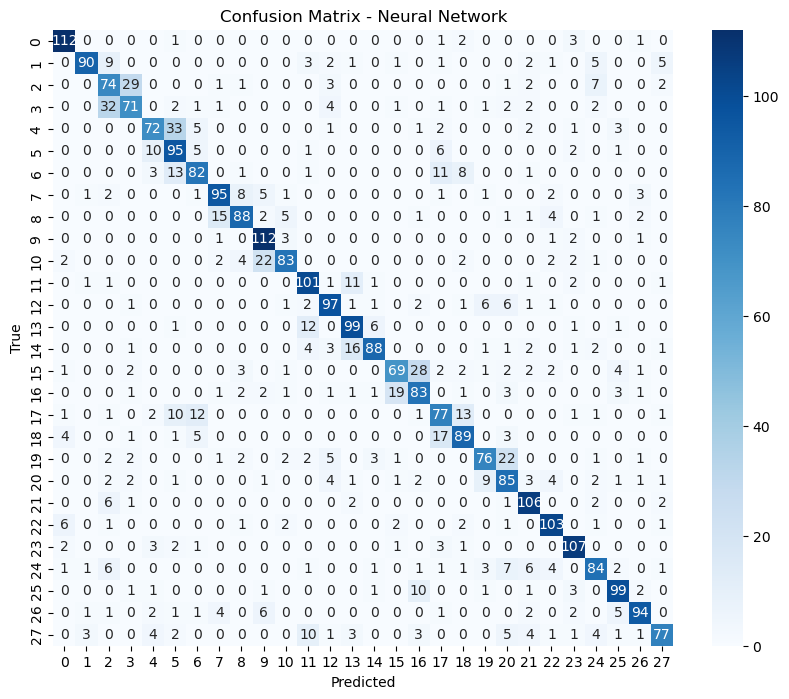

In [23]:
conf_matrix = confusion_matrix(true_classes, pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Neural Network")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [24]:
svm_conf_matrix = confusion_matrix(test_label, svm_preds)

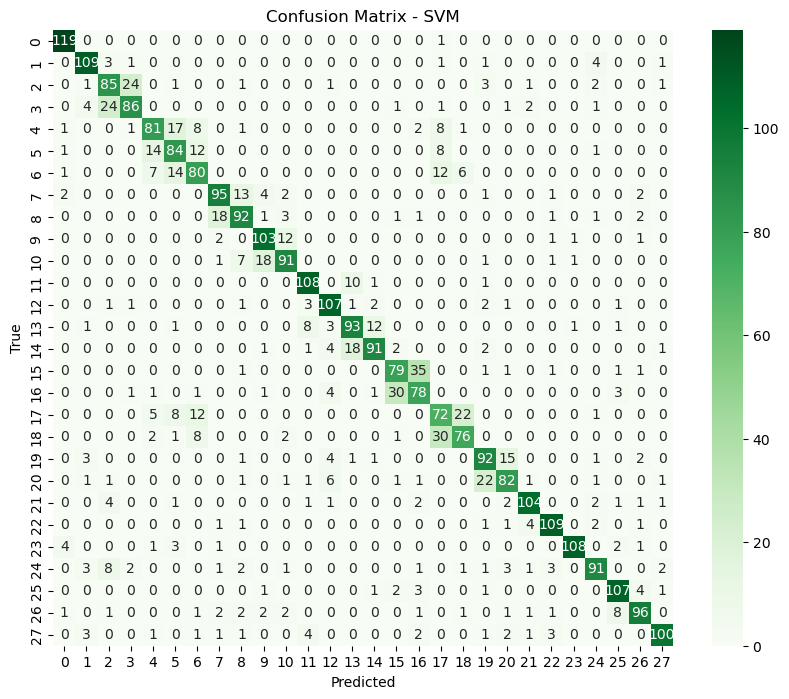

In [25]:
plt.figure(figsize=(10, 8))
sns.heatmap(svm_conf_matrix, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - SVM")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [ ]:
from tensorflow.keras.models import load_model
import tensorflow as tf

In [27]:
best_model.save('best_arabic_model.h5')
model = tf.keras.models.load_model('best_arabic_model.h5')

In [28]:
data = pd.read_csv(r'C:\Users\Dell\OneDrive\Desktop\Level 3\ML\ProjectDataset-Arabic-Characters-Recognition\Arabic-Characters-Recognition\csvTestImages 3360x1024.csv', header=None)


In [29]:
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_35 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 29)             │         3,741 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 692,767 (2.64 MB)

 Trainable params: 692,765 (2.64 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [30]:
class_to_char = {
    0: 'ا', 1: 'ب', 2: 'ت', 3: 'ث', 4: 'ج', 5: 'ح', 6: 'خ', 7: 'د', 8: 'ذ', 9: 'ر',
    10: 'ز', 11: 'س', 12: 'ش', 13: 'ص', 14: 'ض', 15: 'ط', 16: 'ظ', 17: 'ع', 18: 'غ',
    19: 'ف', 20: 'ق', 21: 'ك', 22: 'ل', 23: 'م', 24: 'ن', 25: 'ه', 26: 'و', 27: 'ي',
    28: 'ء'
}

In [31]:
images=data.values.reshape(-1,32*32).astype('float32')/255.0
images.shape

(3360, 1024)

In [32]:
prediction = model.predict(images)
predicted_class = np.argmax(prediction,axis=1)


105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [33]:
predicted_class

array([ 1,  1,  2, ..., 26, 28, 28], dtype=int64)

In [34]:
predict=predicted_class

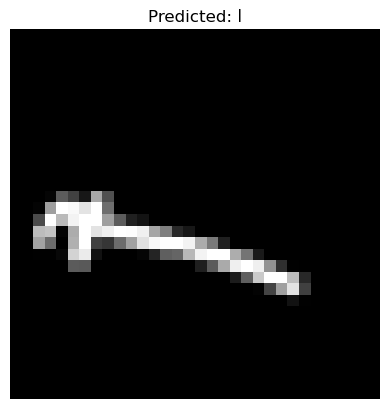

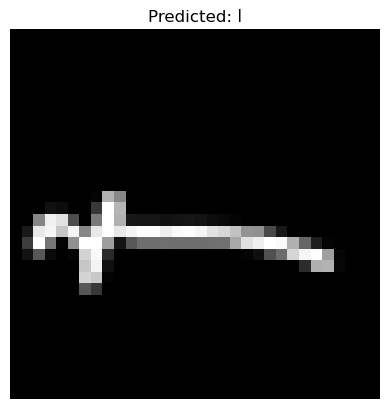

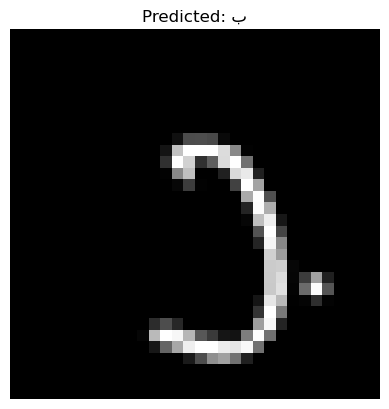

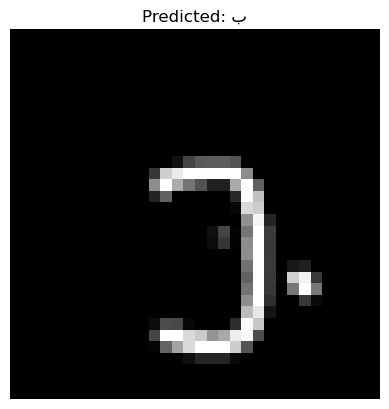

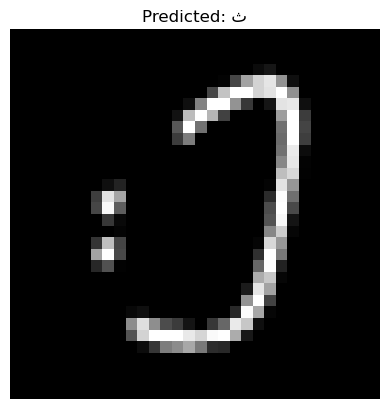

In [ ]:
for i in range(5):
    image = images[i].reshape(32, 32)
    plt.imshow(image, cmap='gray')
    final_pred=class_to_char[predict[i]-1]
    plt.title(f"Predicted: {final_pred}")
    plt.axis('off')
    plt.show()